In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import math
from scipy import interpolate

In [2]:
import cv2

# Load Test images

In [4]:
# find and load test images
images = [ mpimg.imread ( i ) for i in glob.glob( 'imgs/*.jpg' ) ]
len( images )

6

# Convert & Threshold Colors

In [5]:
def convert_rbg_to_grayscale( img: np.ndarray ) -> np.ndarray:
    ## channel-dependent luminance perception --> 0.2989-R 0.5870-G 0.1140-B
    return np.dot( img[ ..., :3 ], [ 0.299, 0.587, 0.114 ] ).astype( np.uint8 )

def convert_rgb_to_hsv( img: np.ndarray ) -> np.ndarray:
    return cv2.cvtColor( img, cv2.COLOR_RGB2HLS )

def select_hsv_white_yellow( img: np.ndarray, hsv: np.ndarray ) -> np.ndarray:
    white_mask = cv2.inRange( hsv, ( 0, 200, 0 ), ( 255, 255, 255 ) )
    yellow_mask = cv2.inRange( hsv, ( 10,   0, 100 ), ( 40, 255, 255 ) )
    return cv2.bitwise_and( img, img, mask = white_mask ) + cv2.bitwise_and( img, img, mask = yellow_mask )

# Remove Noise "Gaussian"

In [6]:
def remove_noise( img: np.ndarray, kernel_size: int) -> np.ndarray:
    # implementation Gaussian Noise Removal
    sigma = 1.0
    pad = kernel_size // 2
    out = np.zeros_like( img )
    img_padded = np.pad( img, pad, mode = 'constant' ) # pad with zeros around image
    kernel = np.zeros( ( kernel_size, kernel_size ) )
    
    for i in range( kernel_size ):
        for j in range( kernel_size ):
            x, y = i - pad, j - pad
            kernel[i,j] = np.exp( - ( x**2 + y**2 ) / ( 2 * sigma**2 ) ) / ( 2 * np.pi * sigma**2 )
    
    for i in range( img.shape[0] ):
        for j in range( img.shape[1] ):
            x = i + pad
            y = j + pad
            out[i, j] = ( kernel * img_padded[ i : i + kernel_size, j : j + kernel_size ] ).sum()
    return out

In [7]:
def gradient( img: np.ndarray, kernel_size: int = 3 ):
    # check kernel_size is 2 or 3 or 5
    assert kernel_size in [ 2, 3, 5 ]
    
    # sobel
    if kernel_size == 2:
        kernel = np.array(
            [
                [
                    [ 1, 0 ], 
                    [ 0, -1 ], 
                ],
                [
                    [ 0, 1 ],
                    [ -1, 2 ] 
                ]
            ]
        )
    if kernel_size == 3:
        kernel = np.array(
            [
                [
                    [-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]
                ],
                [
                    [-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1] 
                ]
            ]
        )
    if kernel_size == 5:
        kernel = np.array(
            [
                [
                    [-1, -2, 0, 2, 1], 
                    [-4, -8, 0, 8, 4], 
                    [-6, -12, 0, 12, 6],
                    [-4, -8, 0, 8, 4],
                    [-1, -2, 0, 2, 1]
                ],
                [
                    [1, 4, 6, 4, 1], 
                    [2, 8, 12, 8, 2],
                    [0, 0, 0, 0, 0], 
                    [-2, -8, -12, -8, -2],
                    [-1, -4, -6, -4, -1]
                ]
            ]
        )
    pad = kernel_size // 2
    Gx = np.zeros_like( img )
    Gy = np.zeros_like( img )
    # Add padding with zeros around image
    img_padded = np.pad( img, pad, mode='constant' )
    
    for i in range( img.shape[0] ):
        for j in range( img.shape[1] ):
            x = i + pad
            y = j + pad
            mask = img_padded[ i : i + kernel_size, j : j + kernel_size ] 
            Gx[i, j] = np.sum( kernel[0] * mask )
            Gy[i, j] = np.sum( kernel[1] * mask )
            
    Magnitudes = np.hypot( Gy, Gx ).astype( 'uint8' )
    Magnitudes = Magnitudes / np.max( Magnitudes ) * 255
    
    angles = np.arctan2( Gy, Gx ).astype( 'uint8' ) * 180 / np.pi
    #angles[ angles < 0 ] += 180 
    
    return Magnitudes, angles

# Canny Edge Detector

In [8]:
weak = 75
low_threshold = 50
high_threshold = 150

In [9]:
def gradient( img: np.ndarray, kernel_size: int = 3 ):
    # check kernel_size is 2 or 3 or 5
    assert kernel_size in [ 2, 3, 5 ]
    
    # sobel
    if kernel_size == 2:
        kernel = np.array(
            [
                [
                    [ 1, 0 ], 
                    [ 0, -1 ], 
                ],
                [
                    [ 0, 1 ],
                    [ -1, 2 ] 
                ]
            ]
        )
    if kernel_size == 3:
        kernel = np.array(
            [
                [
                    [-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]
                ],
                [
                    [-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1] 
                ]
            ]
        )
    if kernel_size == 5:
        kernel = np.array(
            [
                [
                    [-1, -2, 0, 2, 1], 
                    [-4, -8, 0, 8, 4], 
                    [-6, -12, 0, 12, 6],
                    [-4, -8, 0, 8, 4],
                    [-1, -2, 0, 2, 1]
                ],
                [
                    [1, 4, 6, 4, 1], 
                    [2, 8, 12, 8, 2],
                    [0, 0, 0, 0, 0], 
                    [-2, -8, -12, -8, -2],
                    [-1, -4, -6, -4, -1]
                ]
            ]
        )
    pad = kernel_size // 2
    Gx = np.zeros_like( img )
    Gy = np.zeros_like( img )
    # Add padding with zeros around image
    img_padded = np.pad( img, pad, mode='constant' )
    
    for i in range( img.shape[0] ):
        for j in range( img.shape[1] ):
            x = i + pad
            y = j + pad
            mask = img_padded[ i : i + kernel_size, j : j + kernel_size ] 
            Gx[i, j] = np.sum( kernel[0] * mask )
            Gy[i, j] = np.sum( kernel[1] * mask )
            
    Magnitudes = np.hypot( Gy, Gx ).astype( 'uint8' )
    Magnitudes = Magnitudes / np.max( Magnitudes ) * 255
    
    angles = np.arctan2( Gy, Gx ).astype( 'uint8' ) * 180 / np.pi
    #angles[ angles < 0 ] += 180 
    
    return Magnitudes, angles

In [10]:
def non_max_suppression( img: np.ndarray, angle: np.ndarray ) -> np.ndarray:
    out = np.zeros_like( img )
    for i in range( 1, img.shape[0] - 1 ):
        for j in range( 1, img.shape[1] - 1 ):
            q = 255
            r = 255
            #angle 0
            if ( 0 <= angle[i,j] < 22.5 ) or ( 157.5 <= angle[i,j] <= 180 ):
                q = img[i, j+1]
                r = img[i, j-1]
            #angle 45
            elif ( 22.5 <= angle[i,j] < 67.5 ):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            #angle 90
            elif ( 67.5 <= angle[i,j] < 112.5 ):
                q = img[i+1, j]
                r = img[i-1, j]
            #angle 135
            elif ( 112.5 <= angle[i,j] < 157.5 ):
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if ( img[i,j] >= q ) and ( img[i,j] >= r ):
                out[i,j] = img[i,j]
            else:
                out[i,j] = 0
    return out

In [11]:
def double_threshold( img: np.ndarray, high: int, low: int ) -> np.ndarray:    
    output = np.zeros_like( img )
    img = img.astype( np.float32 )
 
    output[ np.where( img >= high ) ] = 255
    output[ np.where( ( img <= high ) & (img > low ) ) ] = weak
    #output[ np.where( img <  low  ) ] = 0
    return output

In [12]:
def hysteresis( img: np.ndarray, weak, strong=255 ) -> np.ndarray:
    out = img.copy()
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            if img[i,j] == weak:
                if (
                    ( img[i+1, j-1] == strong ) or ( img[i+1, j] == strong ) or ( img[i+1, j+1] == strong )
                    or ( img[i, j-1] == strong ) or ( img[i, j+1] == strong )
                    or ( img[i-1, j-1] == strong ) or ( img[i-1, j] == strong ) or ( img[i-1, j+1] == strong )
                ):
                    out[i, j] = strong
                else:
                    out[i, j] = 0
    return out.astype( np.uint8 )

# Mask image

In [13]:
def mask_image( image ):
    # Mask out the pixels outside the region defined in vertices (set the color to black)
    """
    input: edged image by canny
    output: region surrounded by the 'vertices'
    """
    
    # vertices of polygons, data type must be integer
    vertices = np.array(
        [
            [
                ( 0                    , image.shape[0]        ),
                ( image.shape[1] * .475, image.shape[0] * .575 ), 
                ( image.shape[1] * .525, image.shape[0] * .575 ), 
                ( image.shape[1]       , image.shape[0]        )
            ]
        ], dtype = np.int32
    )
    # mask using vertices to image
    mask = np.zeros_like( image )
    cv2.fillPoly( mask, vertices, 255)
    #plt.figure(); plt.imshow( mask , cmap = 'gray' );    
    return np.bitwise_and( image, mask )

# Hough Line

In [14]:
def hough_line( img, lines_are_white=True, value_threshold=5 ):
    # 1) initialize Hough parameter space rs, thetas
    thetas = np.deg2rad( np.arange( -90.0, 90.0 ) ) #Theta in range from -90 to 90 degrees
    diag_len = int( round( np.hypot( img.shape[0], img.shape[1] ) ) )
    #print( f'diag_len {diag_len}' )
    rhos = np.linspace( -diag_len, diag_len, diag_len * 2 )
    
    cos_t = np.cos( thetas )
    sin_t = np.sin( thetas )
    num_thetas = len( thetas )
    
    # 2) Create accumulator array and initialize to zero 
    accumulator = np.zeros( ( 2 * diag_len, num_thetas ), dtype=np.uint8 )
    
    # 3) Check if it is an edge pixel
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero( are_edges )

    # 4) Loop over each edge pixel (edge_row_idx: has the total array while x has each value)
    for i in range( len( x_idxs ) ): #or len(y_idx) they're the same
        x = x_idxs[i]
        y = y_idxs[i]
        
    # 5) Map edge pixel of edges to hough space
        for t_idx in range( num_thetas ):
            rho = diag_len + int( round( x * cos_t[t_idx] + y * sin_t[t_idx] ) )
            accumulator[rho, t_idx] += 1
            
    # 6) show the hough space--> each pixel mapped to curve with r and theta
    #plt.figure( figsize=(16, 10) ); plt.imshow( accumulator, cmap='jet', extent = [ np.rad2deg( thetas[-1] ), np.rad2deg( thetas[0] ), rhos[-1], rhos[0] ] )
    return accumulator, thetas, rhos

def k_largest_index_argsort( accumulator_hough, lines ): 
    # k is number of lines (number of indices of max. values you want to return)
    idx = np.argsort( accumulator_hough.ravel() )[ : -lines - 1 : -1 ]
    return np.column_stack( np.unravel_index( idx, accumulator_hough.shape ) )

def superimpose_maxima_on_cartesian( accumulator_hough, theta_hough, rho_hough, img2, lines=5 ):
    idx = k_largest_index_argsort( accumulator_hough, lines )
    out = []
    for idx_rho, idx_theta in zip( idx[:, 0], idx[:, 1] ): # or in idx (directly)
        rho_max = int( rho_hough[ idx_rho ] )
        theta_max = theta_hough[ idx_theta ]
        #print( f"rho={rho_max:.0f}, theta={np.rad2deg( theta_max ):.0f}" )
        
        a, b = np.cos( theta_max ), np.sin( theta_max )
        
        x0, y0 = ( a * rho_max ), ( b * rho_max )
        x1, y1 = int( x0 + 1000 * ( -b ) ), int( y0 + 1000 * ( a ) ) 
        x2, y2 = int( x0 - 1000 * ( -b ) ), int( y0 - 1000 * ( a ) )
        
        out.append( [ [ x1, y1, x2, y2 ] ] )
        """
        my_lines = cv2.line( img2, ( x1, y1 ), ( x2, y2 ), ( 255, 0, 0 ), 8 )
        print( ( x1, y1 ), ( x2, y2 ) )
        """;
    return out

In [15]:
def return_slope_intercept( lines ):
    """
    input: lines of hough transform output
    operation: extract (slope, intercept) 
    output: (slope, intercept), (slope, intercept)
    """
    left_lines, left_weights, right_lines, right_weights = [], [], [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue # ignore vertical line
            slope = ( y2 - y1 ) / ( x2 - x1 )
            intercept = y1 - slope * x1
            length = np.hypot( ( y2 - y1 ), ( x2 - x1 ) )
            if slope < 0: # y is reversed in image
                left_lines.append( ( slope, intercept ) )
                left_weights.append( ( length ) )
            else:
                right_lines.append( ( slope, intercept ) )
                right_weights.append( ( length ) )
    # add more weight to longer lines    
    left_lane  = np.dot( left_weights,  left_lines ) / np.sum( left_weights )  if len( left_weights ) > 0 else None
    right_lane = np.dot( right_weights, right_lines ) / np.sum( right_weights ) if len( right_weights ) > 0 else None
    return left_lane, right_lane

def return_line_points( y1, y2, line ):
    """
    input: y1, y2, line
    operation: Convert (slope, intercept) of line --> into pixel points
    output: points 
    """
    if line is not None:
        return ( 
                    ( int( ( y1 - line[1] ) / line[0] ), int( y1 ) ), 
                    ( int( ( y2 - line[1] ) / line[0] ), int( y2 ) )
        ) 
    else: return None

def draw_lines_connected( img, lines, color = [ 255, 0, 0 ], thickness = 8 ):
    
    line_img = np.zeros_like( img )
    y1 = img.shape[0]   # bottom of the image
    y2 = y1 * 0.6       # slightly lower than the middle
    all_lines = return_line_points( y1, y2, return_slope_intercept( lines )[0] ),\
                return_line_points( y1, y2, return_slope_intercept( lines )[1] )
    
    for line in all_lines:
        if line is not None:
            plt.figure( figsize=(16, 10) );cv2.line( line_img, *line,  [255, 0, 0], 20 )
    # image1 * α + image2 * β + λ
    #plt.figure( figsize=(16, 10) ); plt.imshow(line_img)
    out = img * 1.0 + line_img * 0.5
    return out.astype( np.uint8 )

In [16]:
def detect_edges_canny( img, low_threshold, high_threshold ):
    # Canny Edge Detector
    out = remove_noise( img, 5 )
    out, angles = gradient( out, 3 )
    out = non_max_suppression( out, angles )
    out = double_threshold( out, high_threshold, low_threshold )
    out = hysteresis( out, weak )
    return out

In [17]:
def pipeline( img: np.ndarray, low_threshold: int = 10, high_threshold: int = 150 ) -> np.ndarray:
    out1 = img.copy()
    out2 = convert_rgb_to_hsv( out1 )
    out3 = select_hsv_white_yellow( out1, out2 )
    out4 = convert_rbg_to_grayscale( out3 )
    #plt.figure();plt.imshow( out4 );
    
    out5 = detect_edges_canny( out4, low_threshold, high_threshold )
    #plt.figure();plt.imshow( out5 );
    
    out6 = mask_image( out5 )
    #plt.figure();plt.imshow( out6 );
    
    a,b,c = hough_line( out6 )
    out7 = superimpose_maxima_on_cartesian( a, b, c, out1, 160 )
    out8 = draw_lines_connected( out1, out7, color=[255, 0, 0], thickness=18)
    return out8

3
>.<
>.<
>.<


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

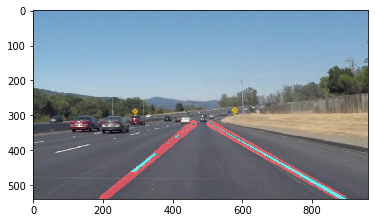

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

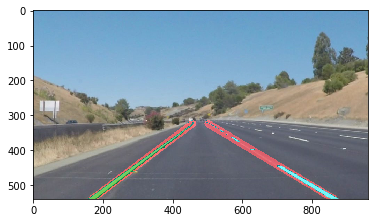

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

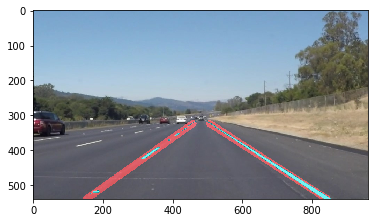

In [19]:
# find and load test images
images = [ mpimg.imread ( i ) for i in glob.glob( 'testCases/*.jpg' ) ]
print( len( images ) )

for i in images:
    a = pipeline( i )
    plt.figure();plt.imshow( a );
    print('>.<')

In [20]:
# !pip install moviepy

In [21]:
from moviepy.editor import VideoFileClip

In [ ]:
vid = VideoFileClip( 'testCases/challengeTest.mp4' )
challenge_clip = vid.fl_image( pipeline )
%time challenge_clip.write_videofile( 'Challenge_output.mp4', audio=False )

In [ ]:
vid = VideoFileClip( 'testCases/SolidWhiteTest.mp4' )
White_clip = vid.fl_image( pipeline )
%time White_clip.write_videofile( 'White Lane_output.mp4', audio=False )

In [ ]:
vid = VideoFileClip( 'testCases/SolidYellowTest.mp4' )
Yello_clip = vid.fl_image( pipeline )
%time Yello_clip.write_videofile( 'Yello Lane_output.mp4', audio=False )